In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import time 

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
q_t = np.load("target_1.npy") # \in \mathcal{R}^{2}
print(q_t.shape)

(2, 60)


Text(0, 0.5, 'Y-axis: velocity of vehicle at time time (v(t))')

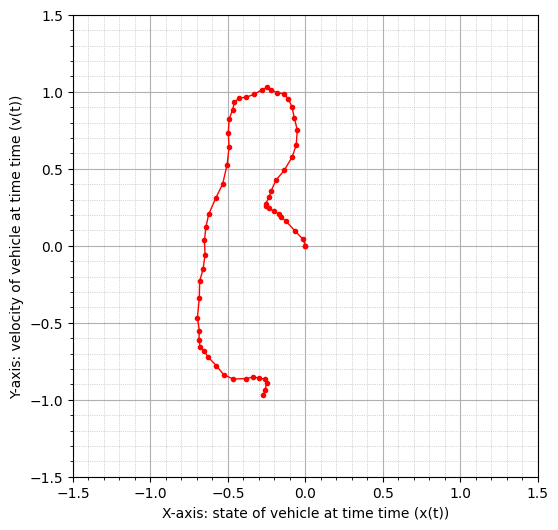

In [4]:
plt.figure(figsize=(6, 6))
plt.xlim([-1.5, 1.5])
plt.ylim([-1.5, 1.5])
plt.plot(q_t[0,:], q_t[1,:], linewidth=1, color='red', linestyle='-')
plt.plot(q_t[0,:], q_t[1,:], 'o', color='red', markersize=3)
plt.grid(True)
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth=0.8)      
plt.grid(which='minor', linestyle=':', linewidth=0.5)   
plt.xlabel('X-axis: state of vehicle at time time (x(t))')
plt.ylabel('Y-axis: velocity of vehicle at time time (v(t))') 


In [5]:
T = 60        # number of time steps
n = 4         # state dimension (p in R^2, v in R^2)

# State trajectory variable: shape (n, T)
x = cp.Variable((n, T))
x_rho = np.zeros((12, n, T))  # reference trajectory variable: shape (n, T)
u_rho = np.zeros((12, 2, T-1))  # reference control input variable: shape (n), T-1)

u = cp.Variable((2, T-1))  # control input variable: shape (2, T-1)

rho = [10, 5, 2, 1, .5, .2, .1, 0.05, 0.02, 0.01, 0.005, 0.002]     # weight for control effort in cost function

E = np.array([[1, 0, 0, 0],
              [0, 1, 0, 0]])  # matrix to extract position from state

A = np.array([[1, 0, 0.1, 0],
                [0, 1, 0, 0.1],
                [0, 0, 0.8, 0],
                [0, 0, 0, 0.8]])  # state transition matrix

B = np.array([[0, 0],
              [0, 0],
              [0.1, 0],
              [0, 0.1]])  # control input matrix

In [6]:
TE = E@x - q_t[0:2, 0: T]


def cost_function(TE, u, rho):
    J = cp.sum_squares(cp.norm(TE, 2)) + rho*cp.sum_squares(cp.norm(u, 2))

    objectives = cp.Minimize(J)
    
    return objectives


In [7]:
constraints = []
for t in range(T-1):
    constraints += [x[:, t+1] == A @ x[:, t] + B @ u[:, t]]  # dynamics constraints

# Initial condition
constraints += [x[:, 0] == np.array([0.5, 0, 1, -1])]  # starting at origin with zero velocity

In [8]:
for i in range(len(rho)):
    r = rho[i]
    objectives = cost_function(TE, u, r)
    prob = cp.Problem(objectives, constraints)
    time_start = time.time()
    result = prob.solve()
    time_end = time.time()
    x_rho[i, :, :] = x.value
    u_rho[i, :, :] = u.value
    print("Optimal value: ", result)
    print("Solve time: ", time_end - time_start)

Optimal value:  109.15292226399444
Solve time:  0.572242021560669
Optimal value:  94.66128457745236
Solve time:  0.5348098278045654
Optimal value:  71.61967519203702
Solve time:  1.266110897064209
Optimal value:  55.0534586138812
Solve time:  0.9640629291534424
Optimal value:  40.80034760437097
Solve time:  1.0000298023223877
Optimal value:  25.449358348968453
Solve time:  1.2977042198181152
Optimal value:  16.866924248281073
Solve time:  2.208012104034424
Optimal value:  11.073195118504177
Solve time:  1.8843472003936768
Optimal value:  6.636772604266809
Solve time:  2.5024349689483643
Optimal value:  4.683425837676902
Solve time:  1.6176159381866455
Optimal value:  3.3781177688847555
Solve time:  3.211066961288452
Optimal value:  2.265866170253326
Solve time:  4.0963757038116455


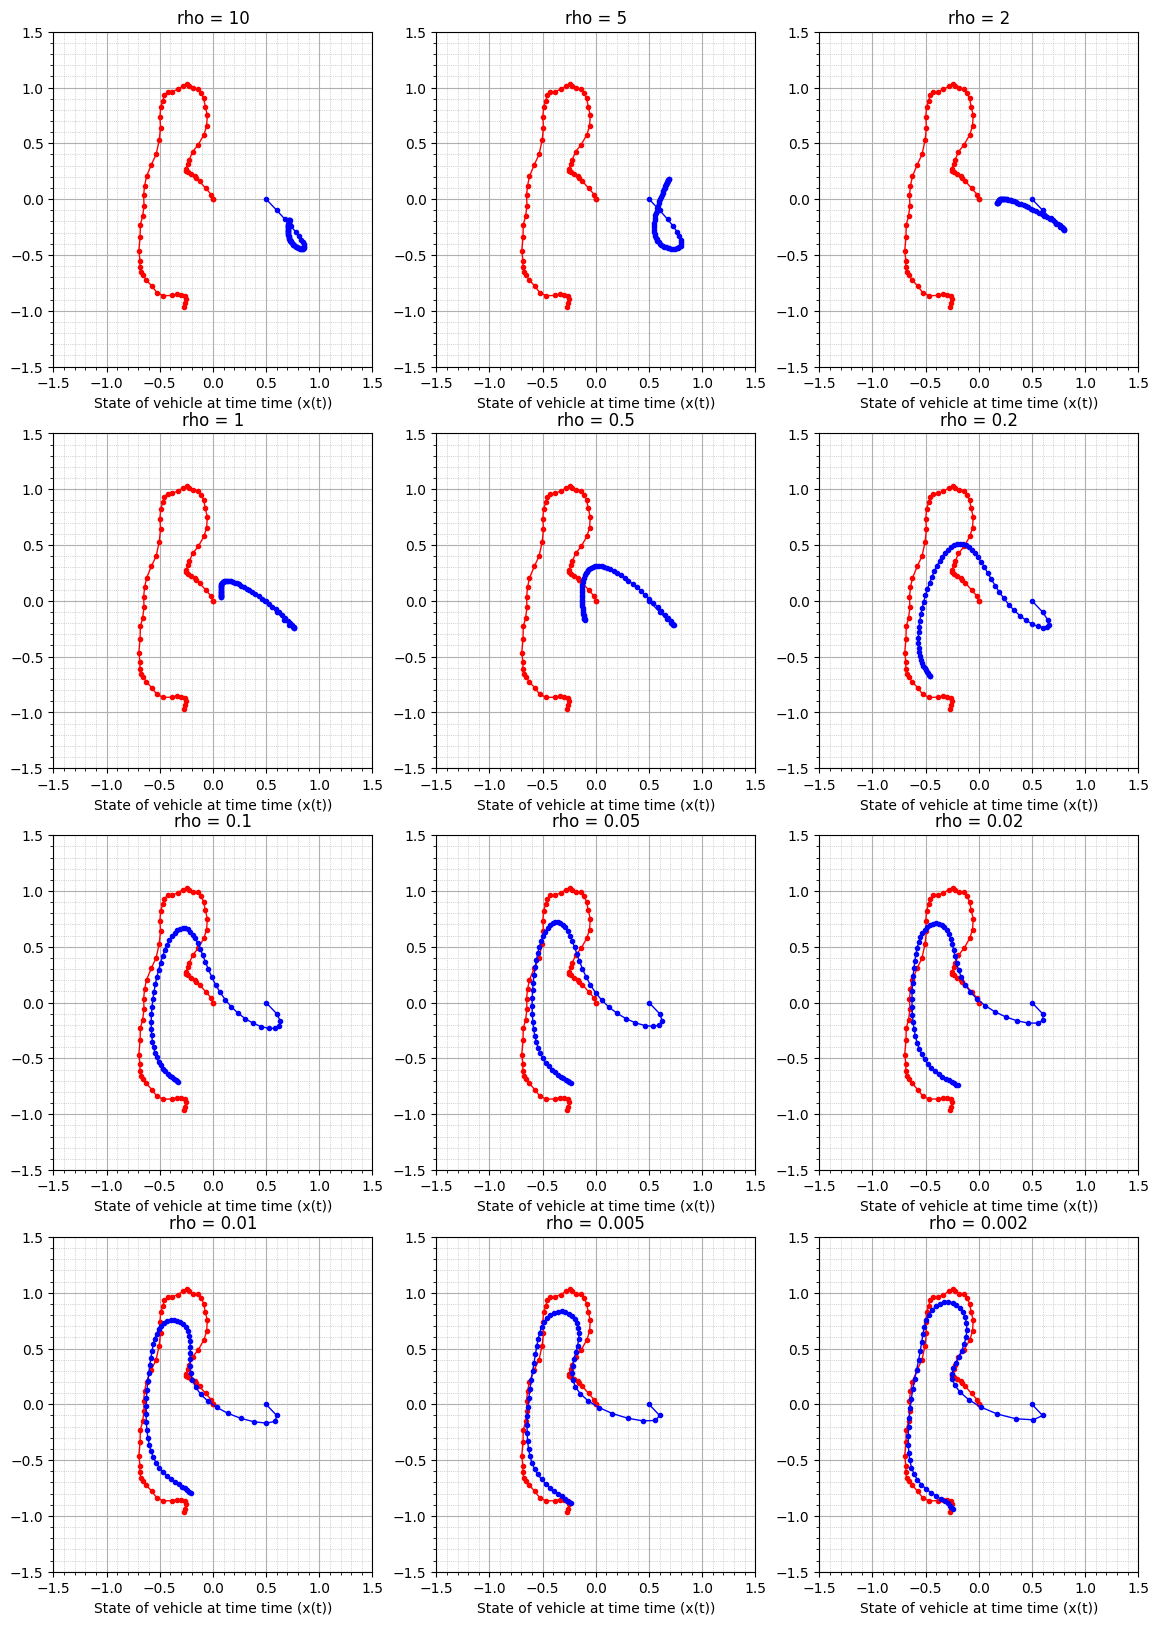

In [9]:
# Create 3x4 subplots (3 rows, 4 cols)
fig, axes = plt.subplots(4, 3, figsize=(14, 20))

# Flatten axes for easy iteration
axes = axes.flatten()

# Plot each trajectory in a separate subplot
for i in range(12):
    ax = axes[i]
    ax.plot(q_t[0, :], q_t[1, :], linewidth=1, color='red', linestyle='-')
    ax.plot(q_t[0, :], q_t[1, :], 'o', color='red', markersize=3)
    ax.plot(x_rho[i, 0, :], x_rho[i, 1, :], linewidth=1, color='blue', linestyle='-')
    ax.plot(x_rho[i, 0, :], x_rho[i, 1, :], 'o', color='blue', markersize=3)
    ax.set_title(f'rho = {rho[i]}')
    ax.set_xlim([-1.5, 1.5])
    ax.set_ylim([-1.5, 1.5])
    ax.grid(True)
    ax.minorticks_on()
    ax.grid(which='major', linestyle='-', linewidth=0.8)      
    ax.grid(which='minor', linestyle=':', linewidth=0.5)   
    ax.set_xlabel('State of vehicle at time time (x(t))')

In [16]:
list = []
for i in range(12):
    TE = np.linalg.norm(E @ x_rho[i, :, :T-1] - q_t[0:2, 0:T-1], axis=0)
    CE = np.linalg.norm(u_rho[i, :, :], axis=0)
    list.append((np.sum(TE), np.sum(CE)))

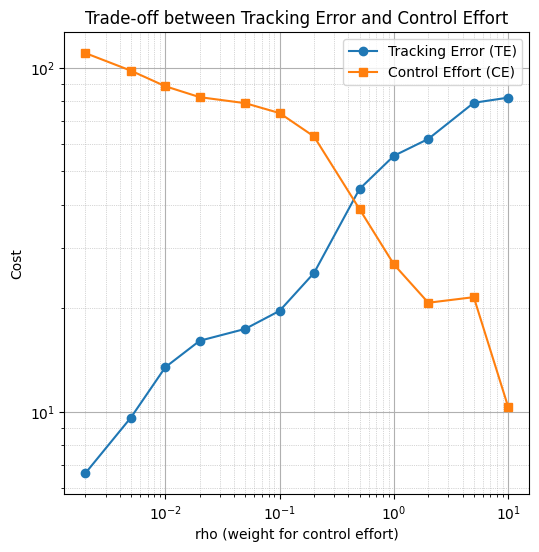

In [19]:
plt.figure(figsize=(6, 6))
plt.plot(rho, [item[0] for item in list], marker='o', label='Tracking Error (TE)')
plt.plot(rho, [item[1] for item in list], marker='s', label='Control Effort (CE)')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('rho (weight for control effort)')
plt.ylabel('Cost')
plt.title('Trade-off between Tracking Error and Control Effort')
plt.legend()
plt.grid(True)
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth=0.8)      
plt.grid(which='minor', linestyle=':', linewidth=0.5)   
plt.show()

/var/folders/fg/1tx5mp094357hs_xr3_kjkkc0000gn/T/ipykernel_3347/423276646.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


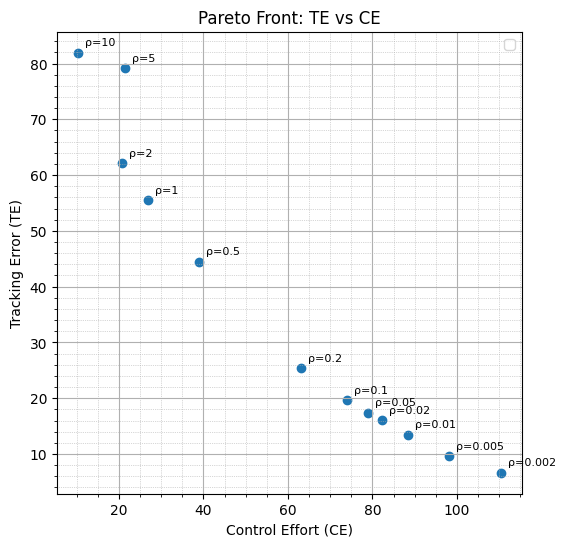

In [27]:
plt.figure(figsize=(6, 6))
x = [item[1] for item in list]  # CE
y = [item[0] for item in list]  # TE

plt.scatter(x, y, marker='o')
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel('Control Effort (CE)')
plt.ylabel('Tracking Error (TE)')
plt.title('Pareto Front: TE vs CE')

# Annotate each point with rho
for (xi, yi, r) in zip(x, y, rho):
    plt.annotate(f"ρ={r}", (xi, yi), textcoords="offset points", xytext=(5,5), fontsize=8)

plt.grid(True)
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth=0.8)      
plt.grid(which='minor', linestyle=':', linewidth=0.5)   
plt.legend()
plt.show()